In [15]:
import pandas as pd
import numpy as np
import os
import scipy as sp
import json
import matplotlib.pyplot as plt 
import seaborn as sns
import biosppy

Signal params:
Fs = 500 Hz

# Load the data

In [4]:
DATA_PATH = '../data/formatted/'

In [5]:
#get a list of files
filenames = [file.split('.')[0] for file in os.listdir(DATA_PATH) if 'json' in file]

# List of meta data
meta_data_list = list()

# Open files and extract meta data
for filename in filenames:
    
    # Import meta dat
    data = json.load(open(DATA_PATH+ f'{filename}.json'))
    meta_data_list.append(data)
    
# Generate DataFrame
meta_data = pd.DataFrame(meta_data_list)

meta_data.head(10)

,age,channel_order,filename,hr,label_train,labels,labels_full,labels_int,sex,shape
0,54,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A2652,57.0316,"[0, 0, 0, 0, 1, 0, 1, 0, 0]","[RBBB, PAC]","[Right bundle branch block, Premature atrial c...","[6, 4]",Male,"[12, 8680]"
1,68,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A4228,59.4477,"[0, 0, 0, 1, 0, 0, 0, 0, 0]",[Normal],[Normal sinus rhythm],[3],Male,"[12, 5000]"
2,40,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A2889,68.4375,"[0, 0, 0, 0, 0, 0, 1, 0, 0]",[RBBB],[Right bundle branch block],[6],Male,"[12, 15500]"
3,83,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A6312,163.366,"[0, 0, 0, 0, 1, 0, 0, 0, 0]",[PAC],[Premature atrial complex],[4],Male,"[12, 5000]"
4,22,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A5549,81.3458,"[0, 0, 0, 0, 0, 0, 1, 0, 0]",[RBBB],[Right bundle branch block],[6],Female,"[12, 11000]"
5,54,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A4279,124.549,"[1, 0, 0, 0, 0, 0, 0, 0, 0]",[AF],[Atrial fibrillation],[0],Female,"[12, 11000]"
6,86,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A3857,88.2573,"[0, 1, 0, 0, 0, 0, 0, 0, 0]",[I-AVB],[First-degree atrioventricular block],[1],Male,"[12, 5000]"
7,28,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A0577,87.7704,"[0, 0, 0, 0, 0, 0, 1, 0, 0]",[RBBB],[Right bundle branch block],[6],Female,"[12, 8055]"
8,39,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A2824,73.2207,"[0, 0, 0, 1, 0, 0, 0, 0, 0]",[Normal],[Normal sinus rhythm],[3],Female,"[12, 5000]"
9,65,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A5921,67.0791,"[0, 0, 0, 0, 0, 0, 1, 0, 0]",[RBBB],[Right bundle branch block],[6],Male,"[12, 5500]"


In [76]:
meta_data.head(1000)

,age,channel_order,filename,hr,label_train,labels,labels_full,labels_int,sex,shape
0,54,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A2652,57.0316,"[0, 0, 0, 0, 1, 0, 1, 0, 0]","[RBBB, PAC]","[Right bundle branch block, Premature atrial c...","[6, 4]",Male,"[12, 8680]"
1,68,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A4228,59.4477,"[0, 0, 0, 1, 0, 0, 0, 0, 0]",[Normal],[Normal sinus rhythm],[3],Male,"[12, 5000]"
2,40,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A2889,68.4375,"[0, 0, 0, 0, 0, 0, 1, 0, 0]",[RBBB],[Right bundle branch block],[6],Male,"[12, 15500]"
3,83,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A6312,163.366,"[0, 0, 0, 0, 1, 0, 0, 0, 0]",[PAC],[Premature atrial complex],[4],Male,"[12, 5000]"
4,22,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A5549,81.3458,"[0, 0, 0, 0, 0, 0, 1, 0, 0]",[RBBB],[Right bundle branch block],[6],Female,"[12, 11000]"
...,...,...,...,...,...,...,...,...,...,...
995,36,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A4038,66.9167,"[0, 0, 0, 0, 0, 0, 1, 0, 0]",[RBBB],[Right bundle branch block],[6],Female,"[12, 10000]"
996,93,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A1810,89.8403,"[0, 1, 0, 0, 0, 0, 0, 0, 0]",[I-AVB],[First-degree atrioventricular block],[1],Male,"[12, 5000]"
997,61,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A2103,61.7311,"[0, 0, 0, 0, 0, 1, 0, 0, 0]",[PVC],[Premature ventricular complex],[5],Male,"[12, 12000]"
998,52,"[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...",A4744,81.8318,"[0, 0, 0, 1, 0, 0, 0, 0, 0]",[Normal],[Normal sinus rhythm],[3],Female,"[12, 5000]"


# Check consistency in channel order

In [45]:
init = meta_data['channel_order'].values[0]
unique = [init]
for i in range(1,meta_data['channel_order'].shape[0]):
    if init != meta_data['channel_order'].values[i]:
        unique.append(meta_data['channel_order'].values[i])

# Check samples/channels

In [51]:
shapes = meta_data['shape'].values

m_0 = np.inf
m_1 = 0

for i in range(shapes.shape[0]):
    if shapes[i][0] < m_0:
        m_0 = shapes[i][0]
    if shapes[i][1] > m_1:
        m_1 = shapes[i][1]

print('Min number of channels: ',m_0)
print('Max number of samples: ',m_1)

Min number of channels:  12
Max number of samples:  72000


# Make plots

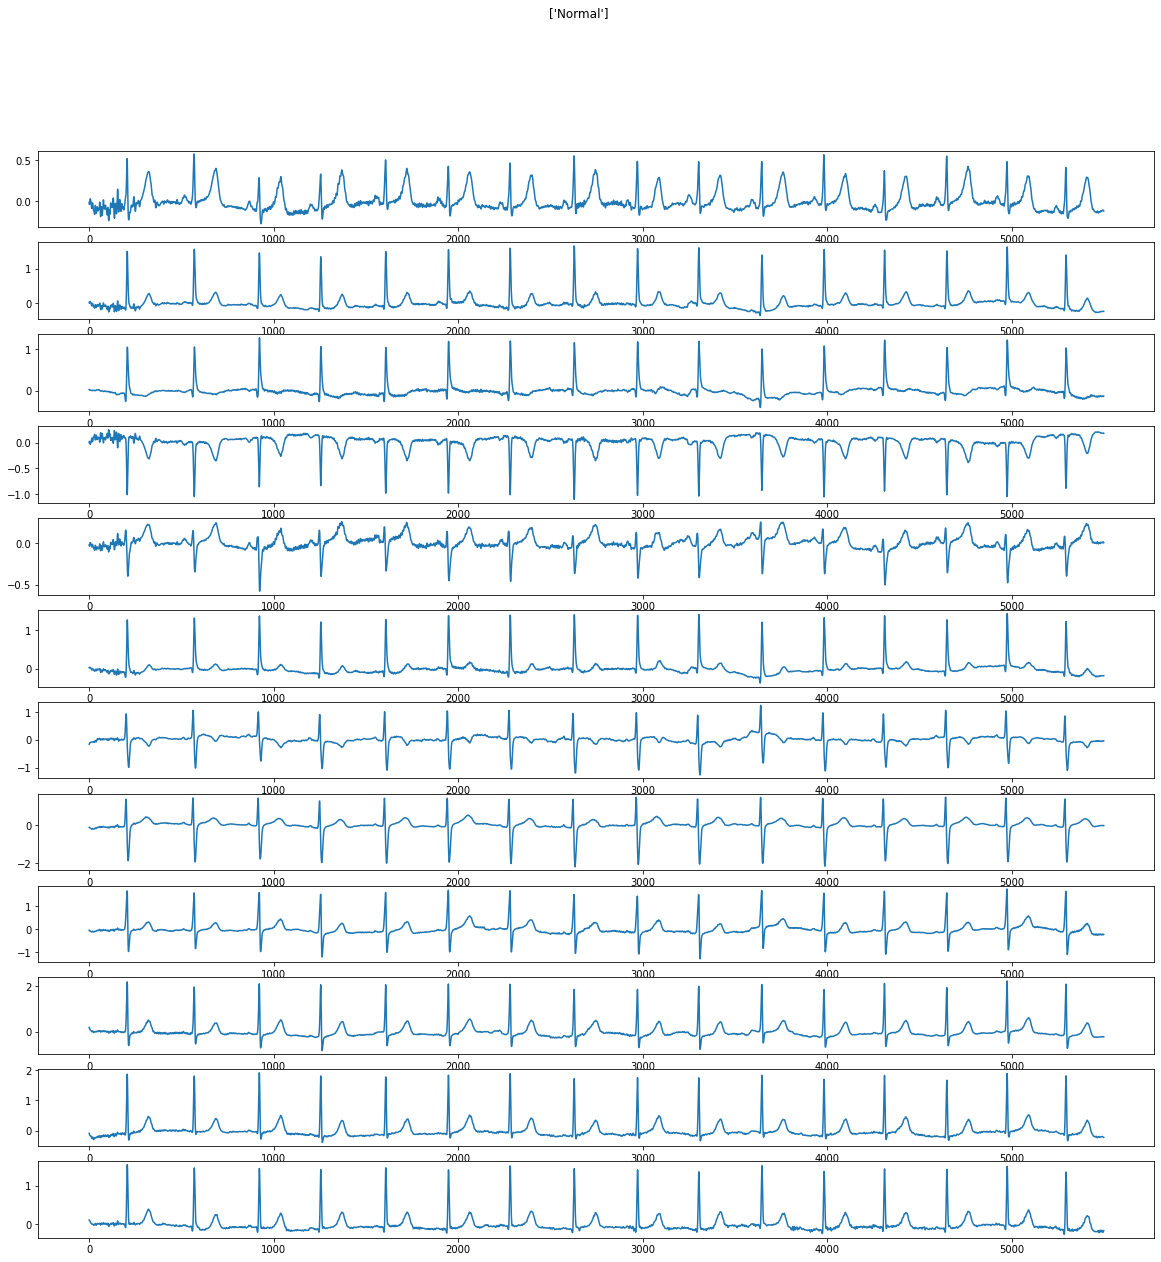

0

In [49]:
def plot_record(record_id,df):
    ecg = np.load(DATA_PATH+df['filename'].values[record_id]+'.npy')
    
    
    #plot the data
    fig,ax = plt.subplots(12,figsize=(20,20))
    fig.suptitle(df['labels'].values[record_id])
    for i in range(ecg.shape[0]):
        ax[i].plot(ecg[i,:])
    plt.show()
    
    return 0

plot_record(record_id=5000,df=meta_data)

# Check distributions of classes

In [111]:
classes = meta_data['label_train'].values
classes_arr = np.array([classes[0]])
classes_arr = np.reshape(classes_arr,(1,-1))

#classes = np.array(classes)

for i in range(1,classes.shape[0]):
    classes_arr = np.concatenate((classes_arr,np.reshape(np.array(classes[i]),(1,-1))),axis=0)
    
classes = np.mean(classes_arr,axis=0)

print('AF: ',np.round(classes[0]*100,3),'%')
print('I-AVB: ',np.round(classes[1]*100,3),'%')
print('LBBB: ',np.round(classes[2]*100,3),'%') #
print('Normal: ',np.round(classes[3]*100,3),'%') 
print('PAC: ',np.round(classes[4]*100,3),'%') 
print('PVC: ',np.round(classes[5]*100,3),'%') 
print('RBBB: ',np.round(classes[6]*100,3),'%') 
print('STD: ',np.round(classes[7]*100,3),'%') 
print('STE: ',np.round(classes[8]*100,3),'%') 

AF:  17.755 %
I-AVB:  10.499 %
LBBB:  3.432 %
Normal:  13.349 %
PAC:  8.957 %
PVC:  10.179 %
RBBB:  27.003 %
STD:  12.636 %
STE:  3.199 %


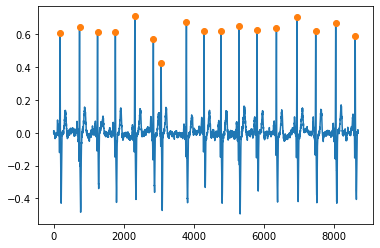

In [122]:
signal = ecg[0,:]
peaks = biosppy.signals.ecg.christov_segmenter(signal=signal, sampling_rate=500)[0]

plt.plot(signal)
plt.plot(peaks,signal[peaks],'o')

# Ideas: 

Pre-rprocessing:
1. remove the baseline wander
2. HRv as a feature
3. RR50
4. downsample
5. some samples are affected by hf-muscle noise
6. age as a feature
7. sex as a fexture?
8. normal vs abnormals softmax loss. final decision based on the rule: normal vs abnormal; which abnormal
9. r peaks position
10. SBD

Models:
1. auxiliary classifier


# Plan: 

1. 